In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import os

from modules import network,mlp
from modules.memory_bank import StaticMemoryBank_for_MSLOSS
from modules.multi_similarity_loss import MultiSimilarityLoss_Boost
from utils import yaml_config_hook,save_model,data_preocess
from evaluation import  evaluation_tools
import warnings
warnings.filterwarnings("ignore")

In [2]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

class_num = args.classnum

In [3]:
x_ndarray,y_ndarray=data_preocess.data_process(x_path='data/PBMC_sorted_filtered_Counts.npz',y_path='data/PBMC_sorted_annoData.txt',args=args)

X Shape: (93661, 2000), Y Shape: (93661, 1)


In [4]:
print(np.unique(y_ndarray))

[ 1  2  3  4  5  6  7  8  9 10]


In [5]:
from torch.utils.data import DataLoader,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features in scDataLoader:
    print(len(features))
    print(len(features[0]))
    break

1
512


In [6]:
mlpp=mlp.MLP()
model=network.Network(mlpp,feature_dim=args.feature_dim)
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

In [7]:
def train(ms_loss,memory_bank,model):
    loss_epoch=0
    for step,data in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        data,pseudolabel=memory_bank.generate_data(data[0].numpy())
        data=torch.tensor(data,dtype=torch.float32).to('cuda')
        pseudolabel=torch.tensor(pseudolabel,dtype=torch.long).to('cuda')
        embedding=model(data)
        loss=ms_loss(embedding,pseudolabel)
        loss.backward()
        optimizer.step()
        loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss:{loss.item()}")
            
    return loss_epoch

In [8]:
def validation(model,x_ndarray,y_ndarray,epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        x=torch.tensor(x_ndarray,dtype=torch.float32).to(device)
        embeddings=model.forward_embedding(x)
        embeddings=embeddings.detach().cpu().numpy()
        results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
        print(f'Epoch {epoch} with KMeans predict label\n' + f"ARI:{round(results['kmeans_ari'], 2)}  " + f"NMI:{round(float(results['kmeans_nmi']), 2)} \n")
        print(f'Epoch {epoch} with Leiden predict label\n' + f"ARI:{round(results['leiden_ari'], 2)}  " + f"NMI:{round(float(results['leiden_nmi']), 2)} \n")
        return results['kmeans_ari'],results['kmeans_nmi']


In [9]:
loss_device=torch.device('cuda')
memory_bank=StaticMemoryBank_for_MSLOSS(args.batch_size,x_ndarray,args.num_genes,args.NN_COUNT,max_elements=args.MAX_ELEMENTS)
ms_loss=MultiSimilarityLoss_Boost(args=args)
losses=[]
aris=[]
nmis=[]


for epoch in range(args.start_epoch, args.epochs+1):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(ms_loss,memory_bank,model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
        ari,nmi = validation(model,x_ndarray,y_ndarray,epoch)
        aris.append(ari)
        nmis.append(nmi)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")


Step [0/182]	 loss:7.129523277282715
Step [2/182]	 loss:7.129363059997559
Step [4/182]	 loss:7.129032611846924
Step [6/182]	 loss:7.128681182861328
Step [8/182]	 loss:7.127986907958984
Step [10/182]	 loss:7.127095699310303
Step [12/182]	 loss:7.125823974609375
Step [14/182]	 loss:7.124773979187012
Step [16/182]	 loss:7.122599124908447
Step [18/182]	 loss:7.1193695068359375
Step [20/182]	 loss:7.1171417236328125
Step [22/182]	 loss:7.111847400665283
Step [24/182]	 loss:7.106870651245117
Step [26/182]	 loss:7.104885101318359
Step [28/182]	 loss:7.097952842712402
Step [30/182]	 loss:7.092677116394043
Step [32/182]	 loss:7.08655309677124
Step [34/182]	 loss:7.08359956741333
Step [36/182]	 loss:7.084782600402832
Step [38/182]	 loss:7.0803327560424805
Step [40/182]	 loss:7.074710369110107
Step [42/182]	 loss:7.069575309753418
Step [44/182]	 loss:7.068826198577881
Step [46/182]	 loss:7.063589572906494
Step [48/182]	 loss:7.060484409332275
Step [50/182]	 loss:7.0571417808532715
Step [52/182]	 

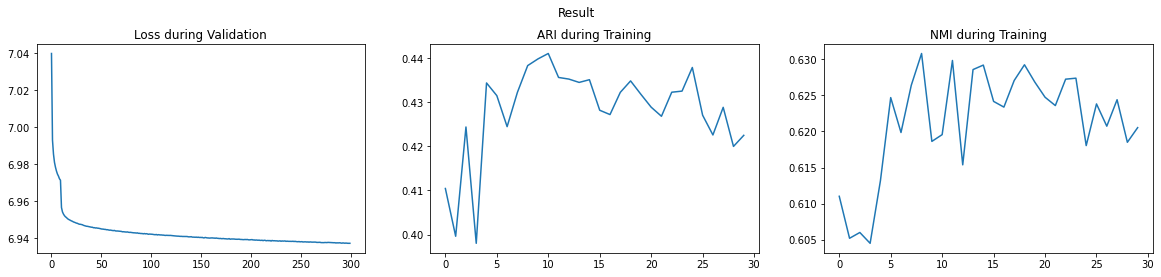

In [10]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
ax[0].plot(losses)
ax[0].set_title('Loss during Validation')
ax[1].plot(aris)
ax[1].set_title('ARI during Training')
ax[2].plot(nmis)
ax[2].set_title('NMI during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

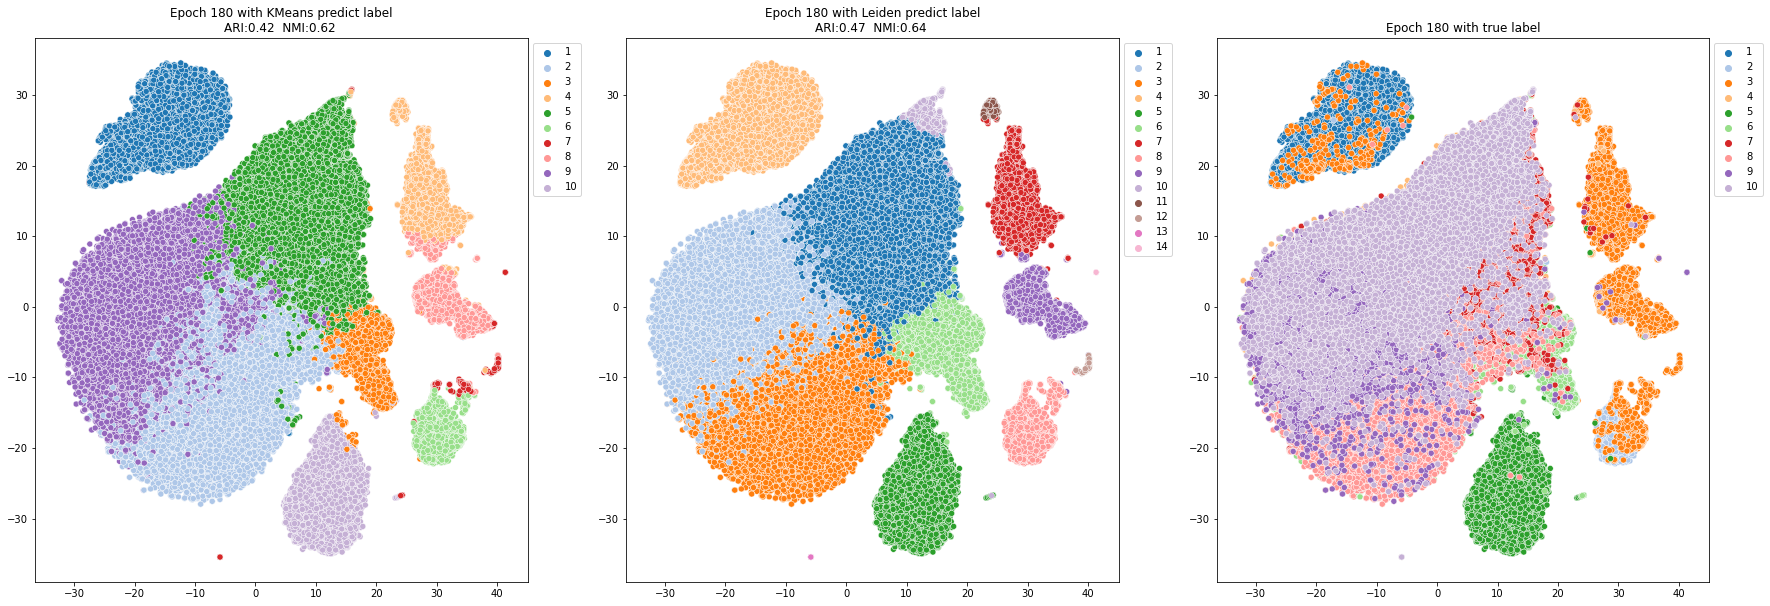

In [5]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save/sc-ms-loss-PBMC-Pos2-Neg10/checkpoint_300.tar')
model.load_state_dict(checkpoint['net'])

model.eval()
with torch.no_grad():
    x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
    embeddings=model.forward_embedding(x)
    embeddings=embeddings.detach().cpu().numpy()
    results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
    evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss-thresh05-margin0-50\checkpoint_30.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_120.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=120)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_60.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=60)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_15.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=30)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_240.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=240)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_300.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=300)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('checkpoint_180.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)
# print(results)